In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%qtconsole

In [3]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import logging
logging.basicConfig(level=logging.INFO)

# np.random.seed(1234)

/Users/edeno/miniconda3/envs/replay_classification/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools



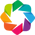

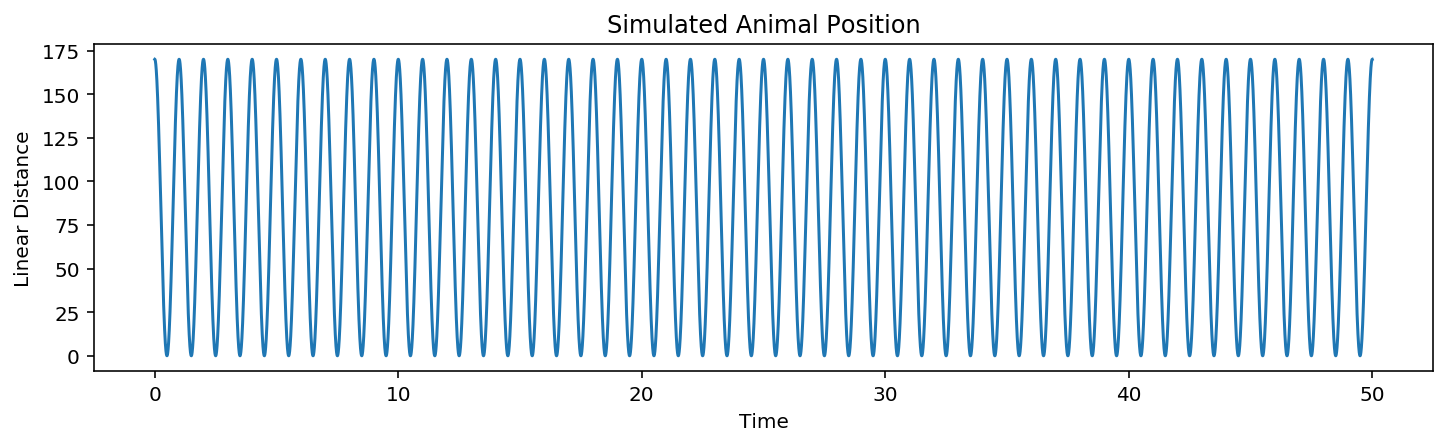

In [4]:
from replay_classification.simulate import simulate_time, simulate_linear_distance

SAMPLING_FREQUENCY = 1500
N_SAMPLES = SAMPLING_FREQUENCY * 50
TRACK_HEIGHT = 170

fig = plt.figure(figsize=(12, 3))
time = simulate_time(N_SAMPLES, SAMPLING_FREQUENCY)
linear_distance = simulate_linear_distance(time, TRACK_HEIGHT)
plt.plot(time, linear_distance);
plt.ylabel('Linear Distance')
plt.xlabel('Time')
plt.title('Simulated Animal Position');

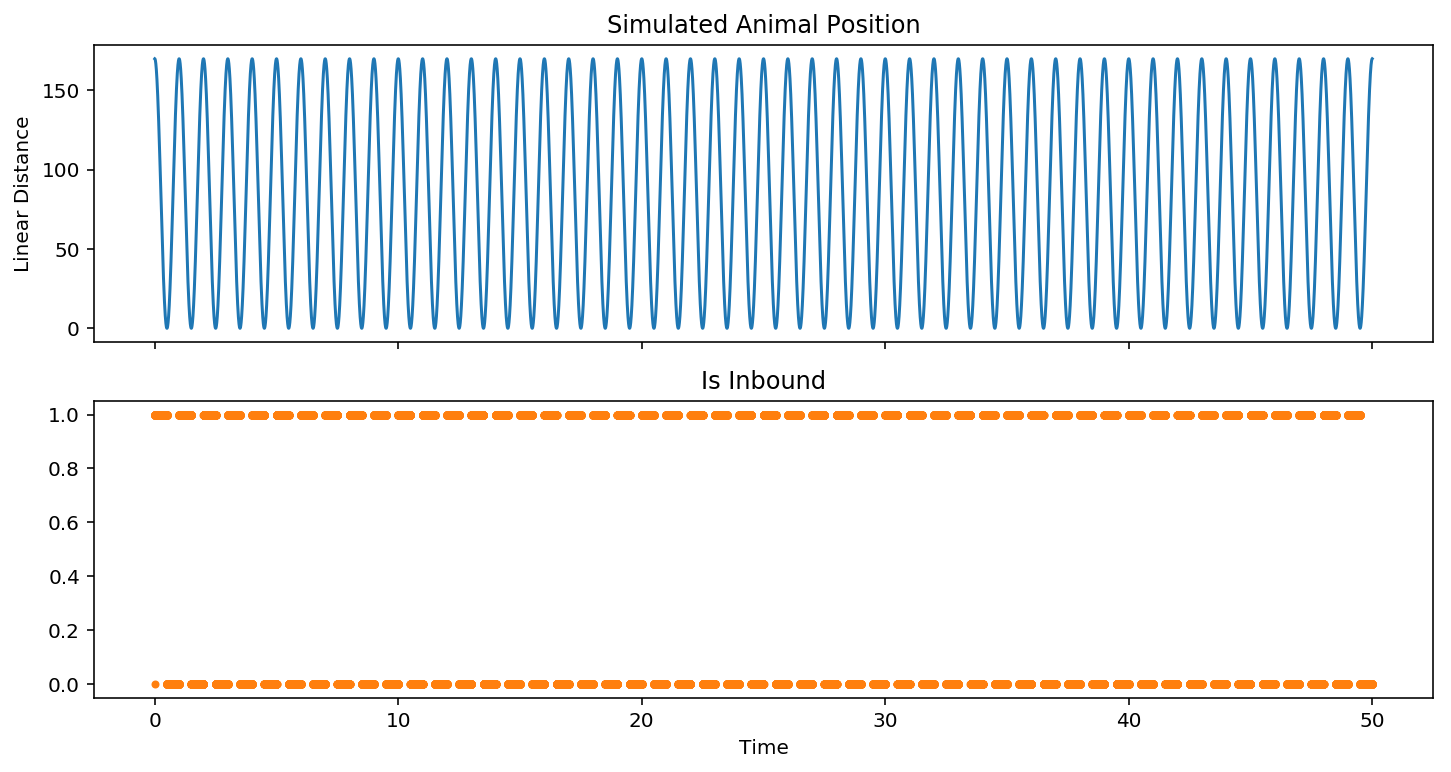

In [5]:
from replay_classification.simulate import get_trajectory_direction
trajectory_direction, is_inbound = get_trajectory_direction(linear_distance)

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axes[0].plot(time, linear_distance);
axes[0].set_ylabel('Linear Distance')
axes[1].set_xlabel('Time')
axes[0].set_title('Simulated Animal Position');

axes[1].plot(time, is_inbound, color='C1', linestyle='None', marker='.')
axes[1].set_title('Is Inbound');

Simulate 4 tetrodes, each of which picks up multiple neurons:
+  tetrode #1 picks up 4 neurons with place fields at 0, 50, 100, 150 cm, all of which only fire on inbound trials
+  tetrode #2 picks up 4 neurons with place fields at 25, 75, 125, 175 cm, all of which only fire on inbound trials
+  tetrode #3 picks up 4 neurons with place fields at 0, 50, 100, 150 cm, all of which only fire on outbound trials
+  tetrode #4 picks up 4 neurons with place fields at 25, 75, 125, 175 cm, all of which only fire on outbound trials

In [6]:
from replay_classification.simulate import simulate_multiunit

mark_means = np.array([200, 125, 325, 275])
place_field_means = np.stack((np.arange(0, 200, 50),
                              np.arange(25, 200, 50)))

spike_marks = np.stack(
    [simulate_multiunit(place_field_means[0], mark_means, linear_distance, SAMPLING_FREQUENCY, is_condition=is_inbound),
     simulate_multiunit(place_field_means[1], mark_means, linear_distance, SAMPLING_FREQUENCY, is_condition=is_inbound),
     simulate_multiunit(place_field_means[0], mark_means, linear_distance, SAMPLING_FREQUENCY, is_condition=~is_inbound),
     simulate_multiunit(place_field_means[1], mark_means, linear_distance, SAMPLING_FREQUENCY, is_condition=~is_inbound),
    ], axis=0)


/Users/edeno/Documents/GitHub/replay_classification/replay_classification/simulate.py:60: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.stack(unit, axis=0), axis=0)


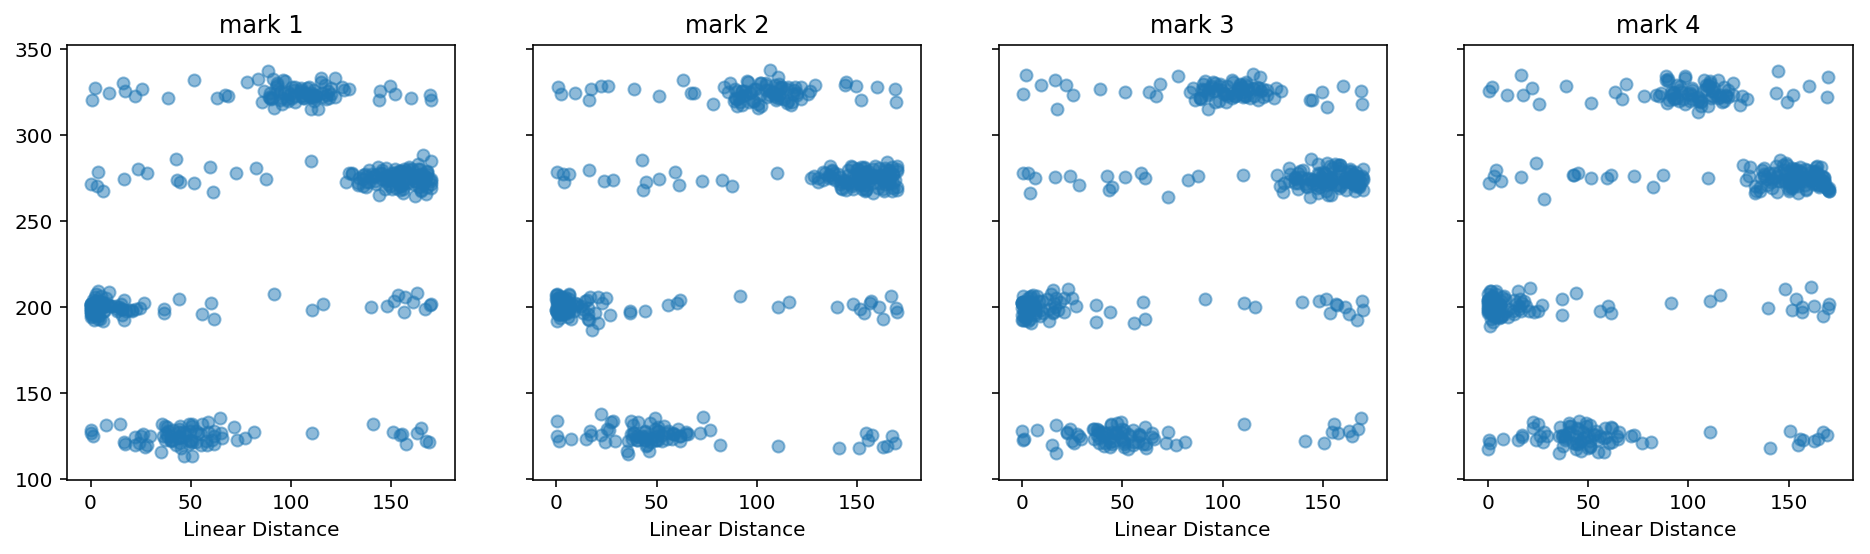

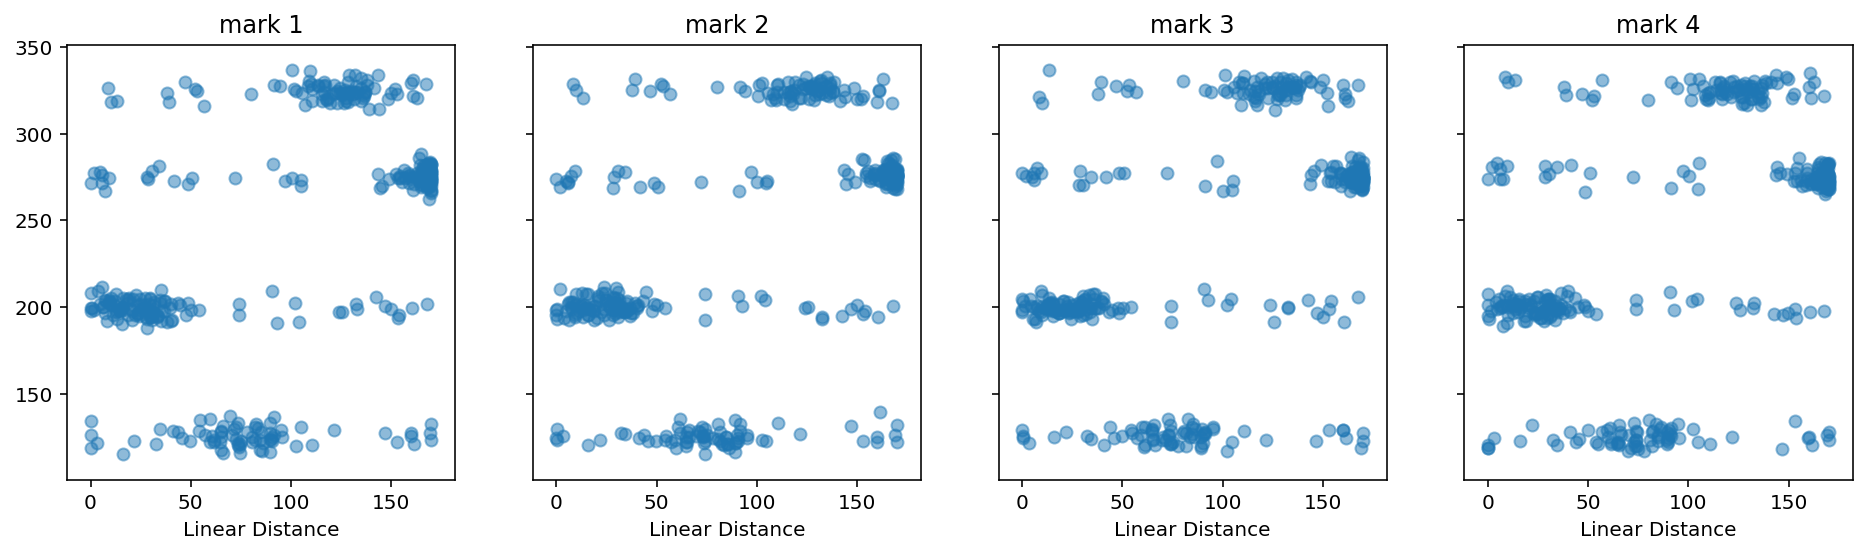

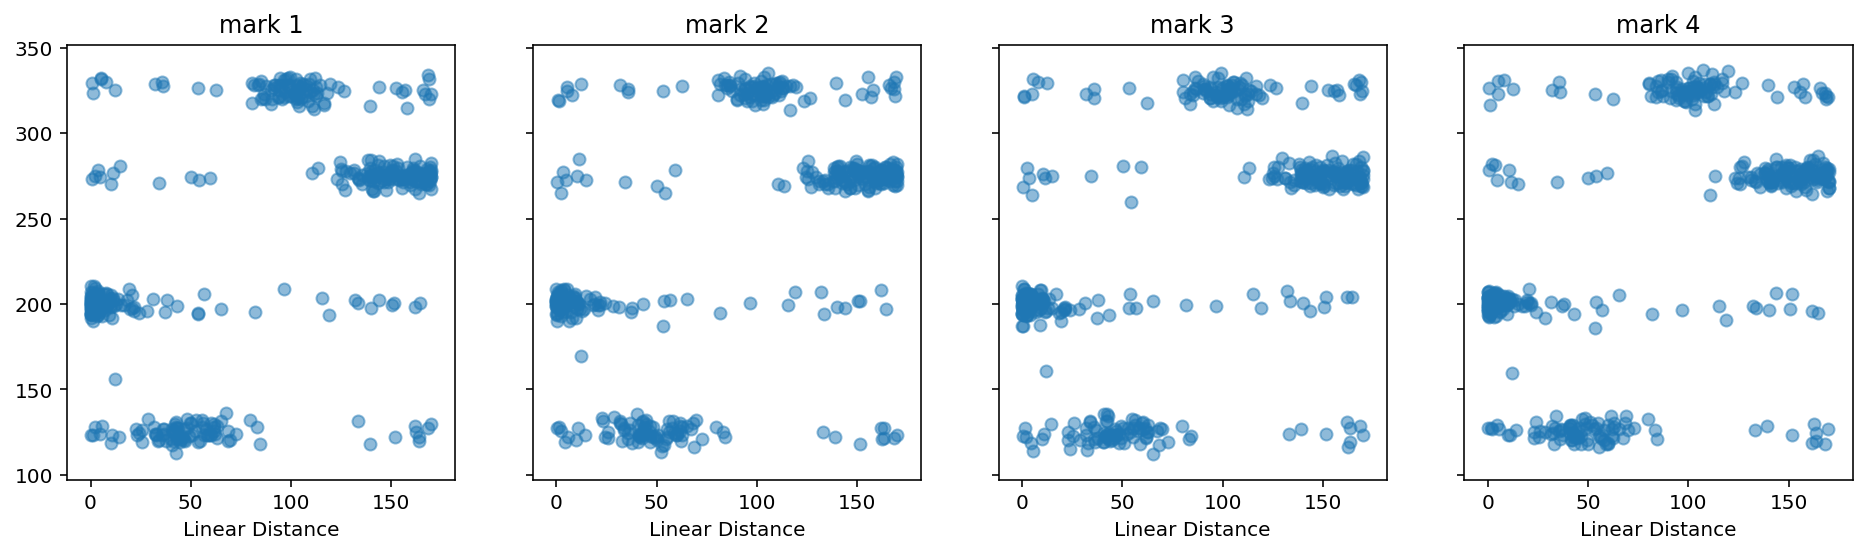

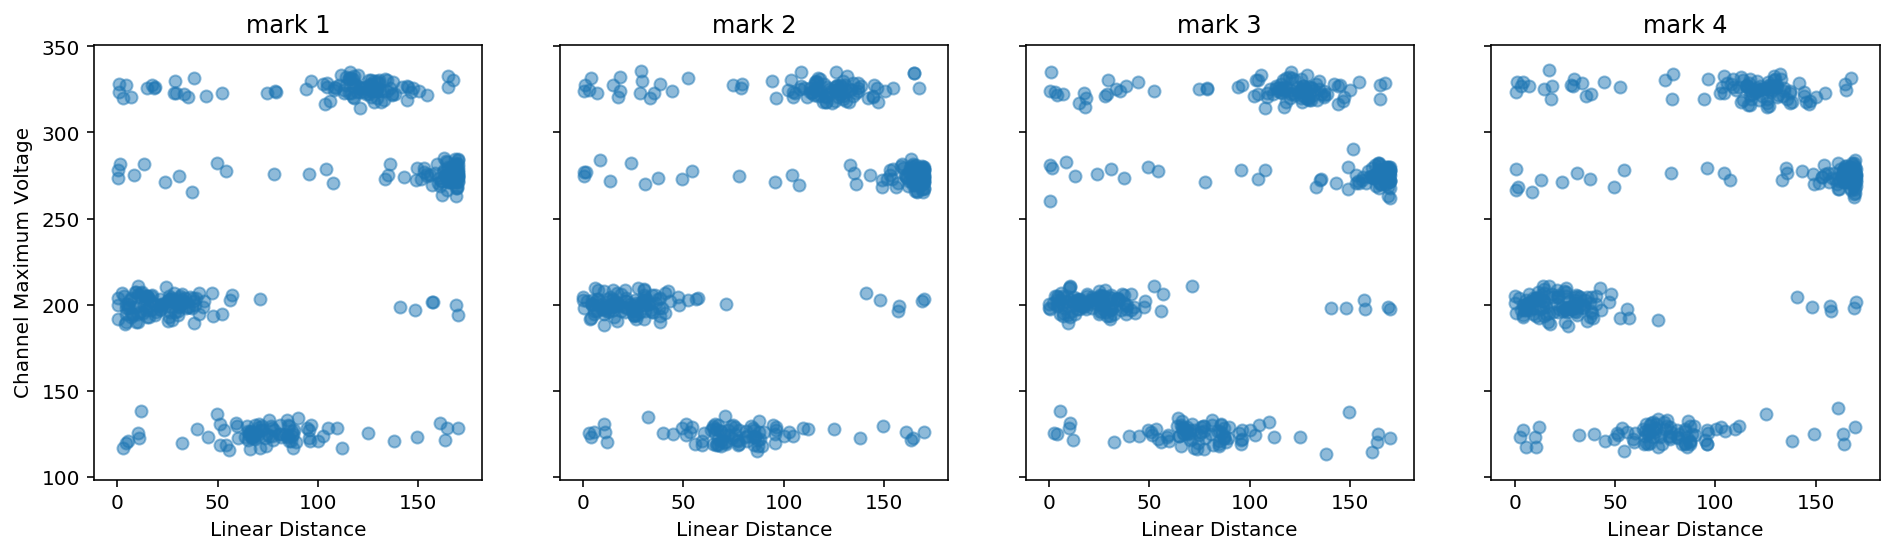

In [7]:
for s in spike_marks:
    fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 4))
    for ind, (ax, m) in enumerate(zip(axes, s.T)):
        ax.scatter(linear_distance, m, alpha=0.5)
        ax.set_xlabel('Linear Distance')
        ax.set_title('mark {0}'.format(ind + 1))
axes[0].set_ylabel('Channel Maximum Voltage');

In [8]:
from replay_classification import ClusterlessDecoder

lagged_linear_distance = np.insert(linear_distance[:-1], 0, linear_distance[0])

decoder = ClusterlessDecoder(
    position=linear_distance,
    lagged_position=lagged_linear_distance,
    trajectory_direction=trajectory_direction,
    spike_marks=spike_marks,
    replay_speedup_factor=1,
)

In [9]:
decoder.fit()

INFO:replay_classification.decoders:Fitting state transition model...
INFO:replay_classification.decoders:Fitting observation model...


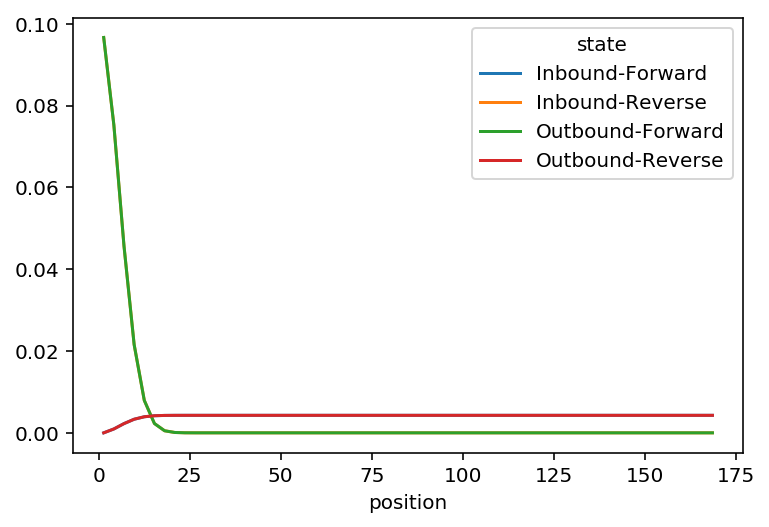

In [10]:
decoder.plot_initial_conditions();

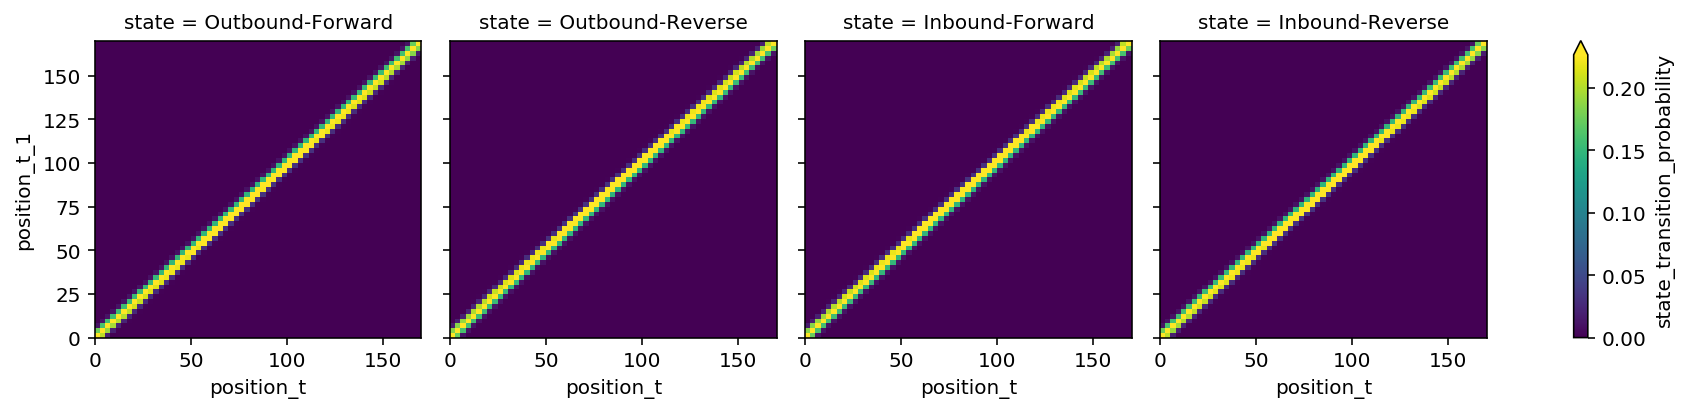

In [11]:
decoder.plot_state_transition_model();

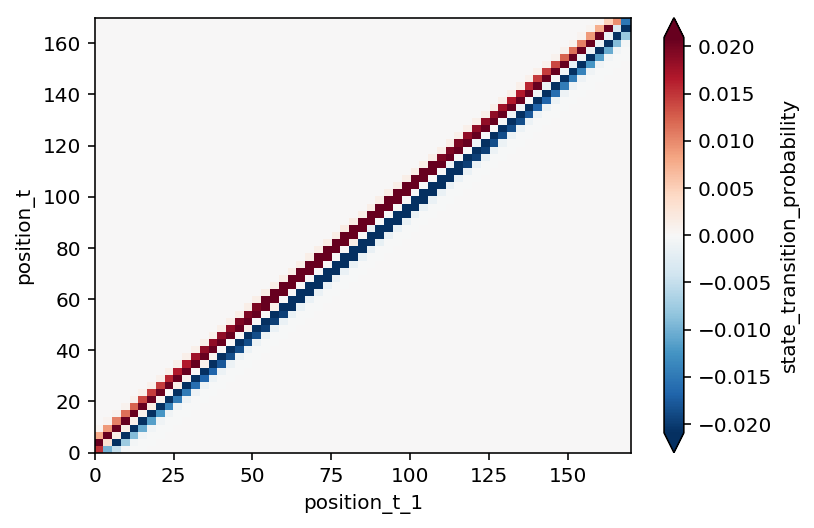

In [12]:
state_transition = decoder.state_transition_matrix

(state_transition.sel(state='Outbound-Forward') - state_transition.sel(state='Inbound-Forward')).plot(
    x='position_t_1', y='position_t', robust=True);

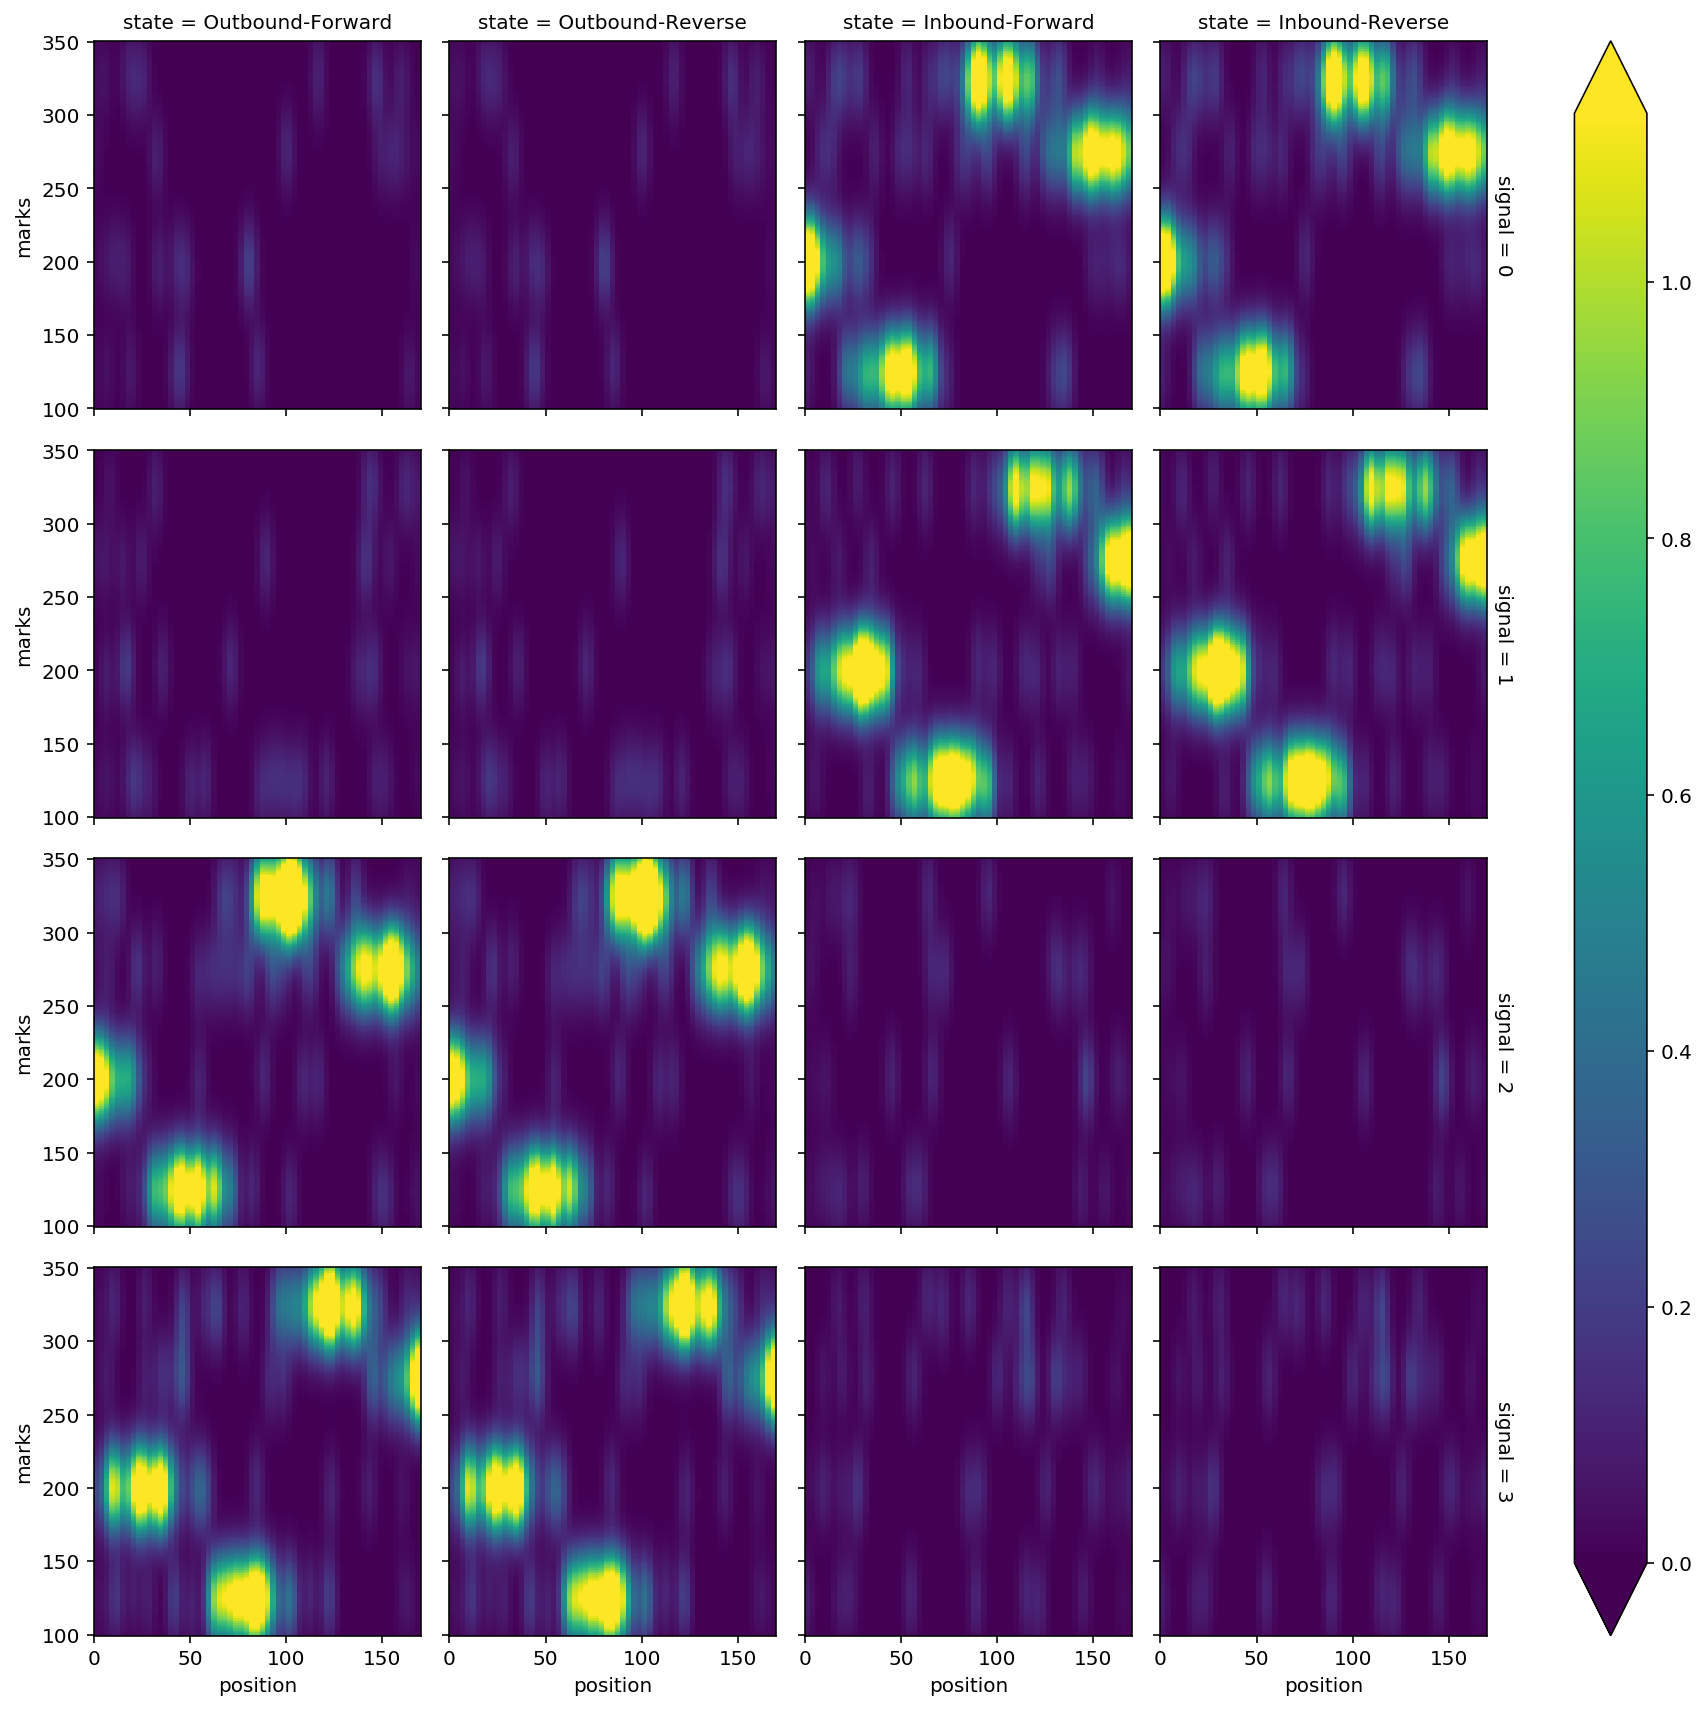

In [12]:
decoder.plot_observation_model(SAMPLING_FREQUENCY);

### Outbound-Forward

In [15]:
outbound_time = (time > 1.5) & (time <= 2)
outbound_results = decoder.predict(spike_marks[:, outbound_time, :], time=time[outbound_time])

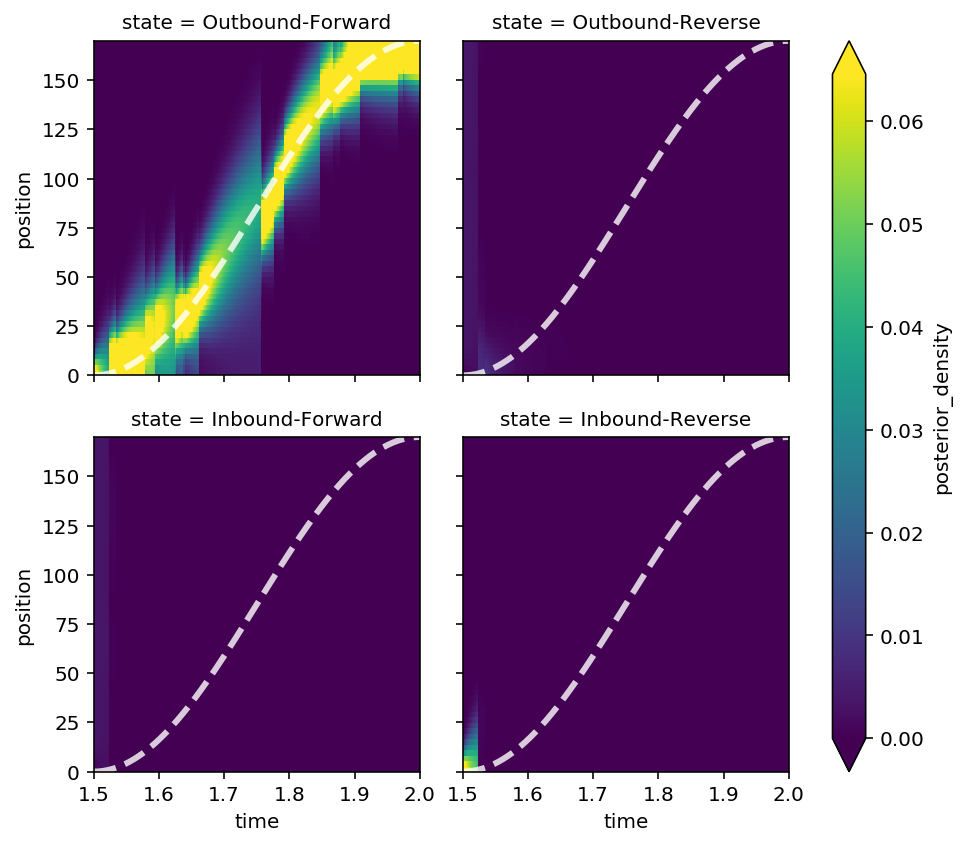

In [16]:
g = outbound_results.plot_posterior_density()

for ax in g.axes.ravel().tolist():
    ax.plot(time[outbound_time], linear_distance[outbound_time], color='white', linestyle='--', linewidth=3, alpha=0.8)

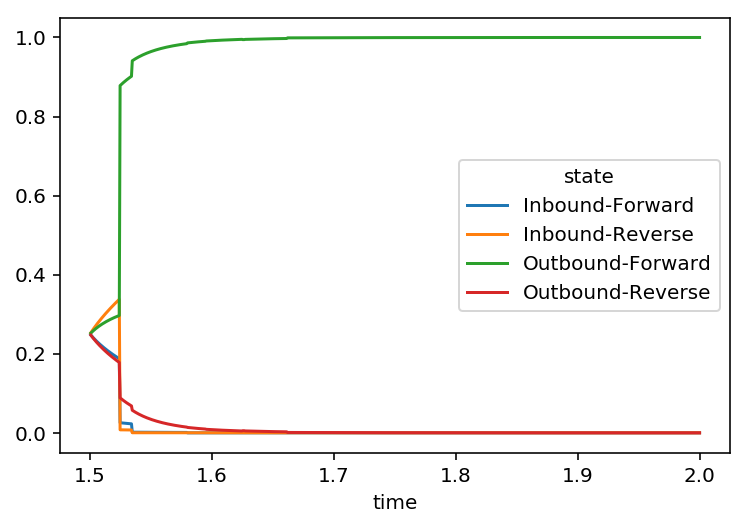

In [17]:
outbound_results.plot_state_probability();

### Inbound-Forward

In [18]:
inbound_time = time < 0.5
inbound_results = decoder.predict(spike_marks[:, inbound_time, :], time=time[inbound_time])

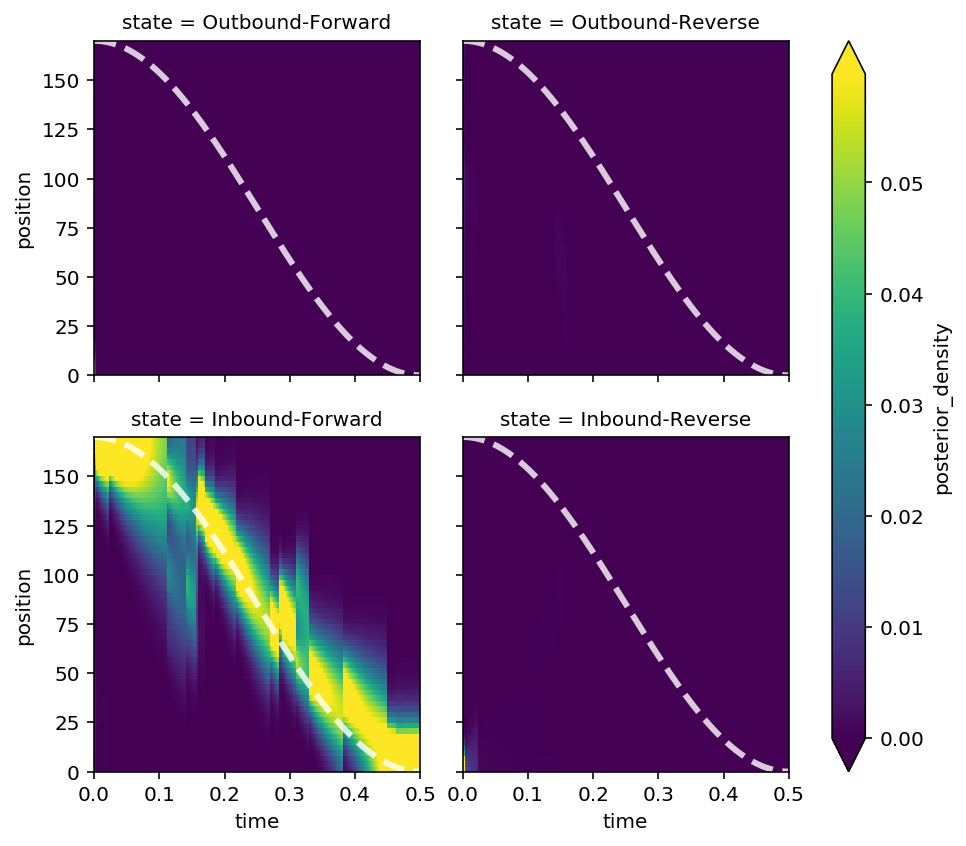

In [19]:
g = inbound_results.plot_posterior_density()

for ax in g.axes.ravel().tolist():
    ax.plot(time[inbound_time], linear_distance[inbound_time], color='white', linestyle='--', linewidth=3, alpha=0.8)

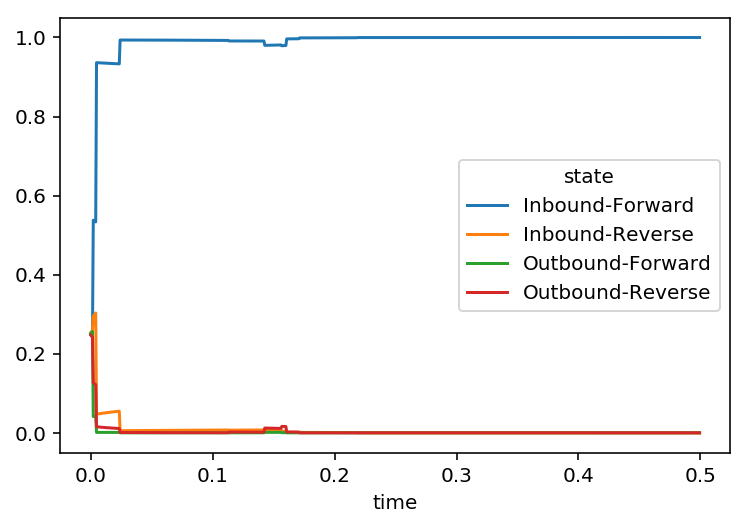

In [20]:
inbound_results.plot_state_probability();

## Simulate Replay

In [20]:
replay_decoder = ClusterlessDecoder(
    position=linear_distance,
    lagged_position=lagged_linear_distance,
    trajectory_direction=trajectory_direction,
    spike_marks=spike_marks,
    replay_speedup_factor=15,
).fit()

n_replay_time = 40
replay_time = simulate_time(n_replay_time, SAMPLING_FREQUENCY)

INFO:replay_classification.decoders:Fitting state transition model...
INFO:replay_classification.decoders:Fitting observation model...


### Outbound-Forward

In [21]:
outbound_forward_spike_marks = np.full((4, n_replay_time, 4), np.nan)
outbound_forward_spike_marks[2, 1, :] = mark_means[0]
outbound_forward_spike_marks[3, 6, :] = mark_means[0]
outbound_forward_spike_marks[2, 11, :] = mark_means[1]
outbound_forward_spike_marks[3, 16, :] = mark_means[1]
outbound_forward_spike_marks[2, 21, :] = mark_means[2]
outbound_forward_spike_marks[3, 26, :] = mark_means[2]
outbound_forward_spike_marks[2, 31, :] = mark_means[3]
outbound_forward_spike_marks[3, 36, :] = mark_means[3]

In [22]:
outbound_forward_results = replay_decoder.predict(outbound_forward_spike_marks, replay_time)

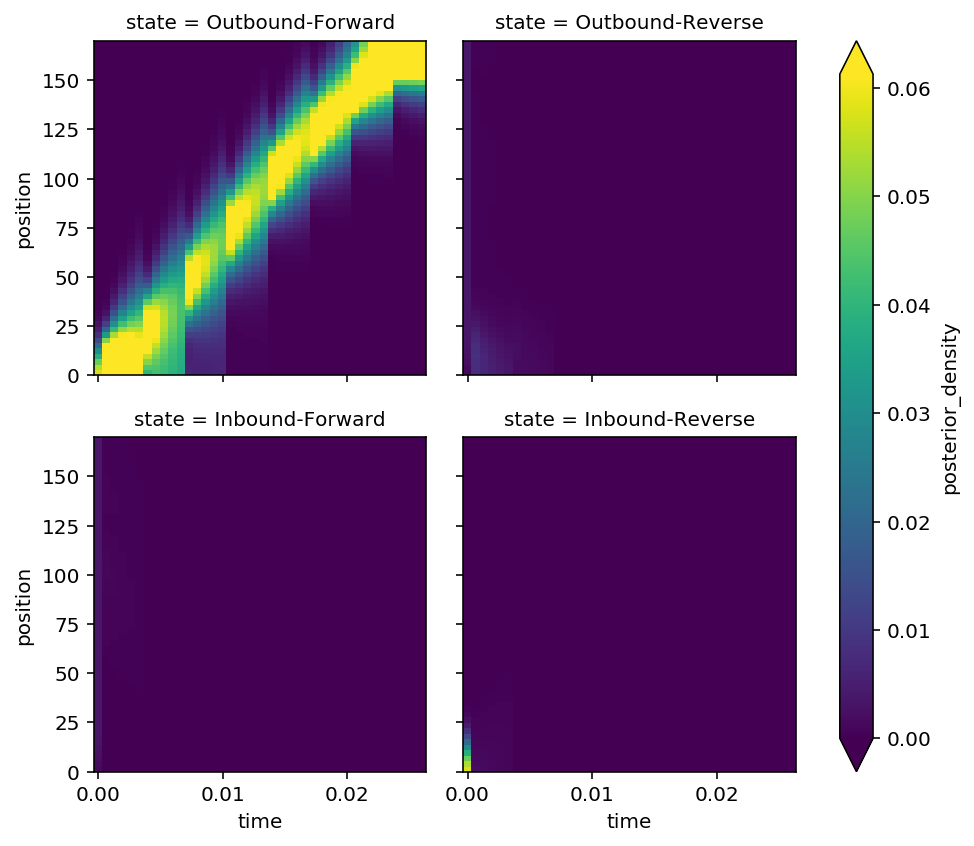

In [23]:
outbound_forward_results.plot_posterior_density()

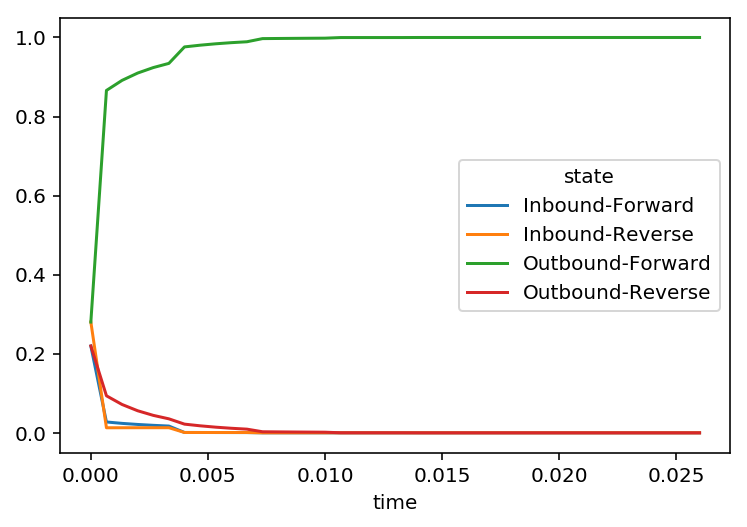

In [24]:
outbound_forward_results.plot_state_probability()

In [322]:
outbound_forward_results.plot_interactive()

:Layout
   .GridSpace.I   :GridSpace   [state]
      :HoloMap   [time]
         :Curve   [position]   (prior)
   .GridSpace.II  :GridSpace   [state]
      :HoloMap   [time]
         :Curve   [position]   (likelihood)
   .GridSpace.III :GridSpace   [state]
      :HoloMap   [time]
         :Curve   [position]   (posterior_density)

### Outbound-Reverse

In [25]:
outbound_reverse_spike_marks = np.full((4, n_replay_time, 4), np.nan)
outbound_reverse_spike_marks[2, 36, :] = mark_means[0]
outbound_reverse_spike_marks[3, 31, :] = mark_means[0]
outbound_reverse_spike_marks[2, 26, :] = mark_means[1]
outbound_reverse_spike_marks[3, 21, :] = mark_means[1]
outbound_reverse_spike_marks[2, 16, :] = mark_means[2]
outbound_reverse_spike_marks[3, 11, :] = mark_means[2]
outbound_reverse_spike_marks[2, 6, :] = mark_means[3]
outbound_reverse_spike_marks[3, 1, :] = mark_means[3]

In [26]:
outbound_reverse_results = replay_decoder.predict(outbound_reverse_spike_marks, replay_time)

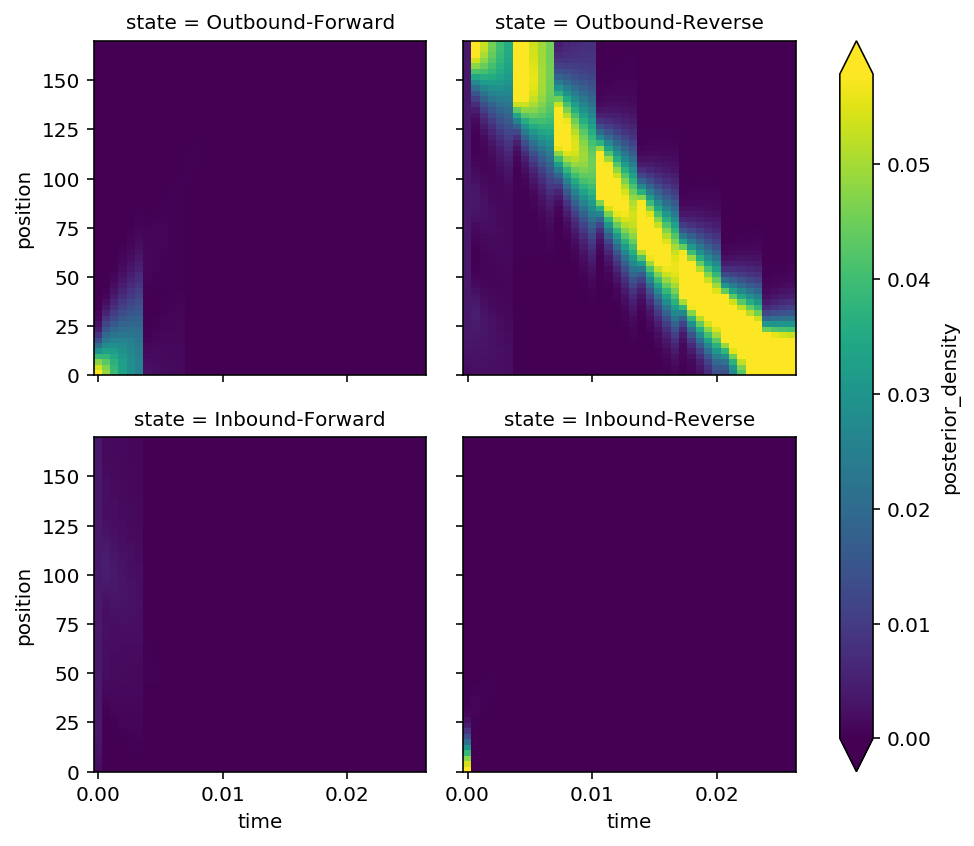

In [27]:
outbound_reverse_results.plot_posterior_density()

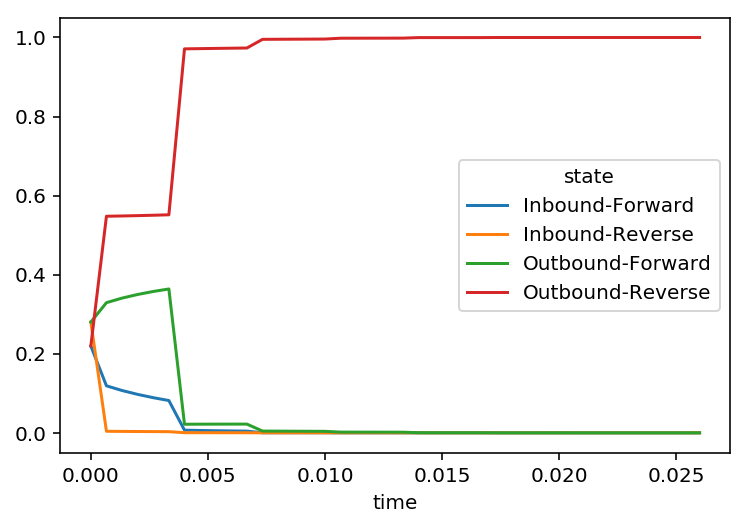

In [28]:
outbound_reverse_results.plot_state_probability()

In [126]:
outbound_reverse_results.plot_interactive()

:Layout
   .GridSpace.I   :GridSpace   [state]
      :HoloMap   [time]
         :Curve   [position]   (prior)
   .GridSpace.II  :GridSpace   [state]
      :HoloMap   [time]
         :Curve   [position]   (likelihood)
   .GridSpace.III :GridSpace   [state]
      :HoloMap   [time]
         :Curve   [position]   (posterior_density)

### Inbound-Forward

In [29]:
inbound_forward_spike_marks = np.full((4, n_replay_time, 4), np.nan)
inbound_forward_spike_marks[0, 36, :] = mark_means[0]
inbound_forward_spike_marks[1, 31, :] = mark_means[0]
inbound_forward_spike_marks[0, 26, :] = mark_means[1]
inbound_forward_spike_marks[1, 21, :] = mark_means[1]
inbound_forward_spike_marks[0, 16, :] = mark_means[2]
inbound_forward_spike_marks[1, 11, :] = mark_means[2]
inbound_forward_spike_marks[0, 6, :] = mark_means[3]
inbound_forward_spike_marks[1, 1, :] = mark_means[3]

In [30]:
inbound_forward_results = replay_decoder.predict(inbound_forward_spike_marks, replay_time)

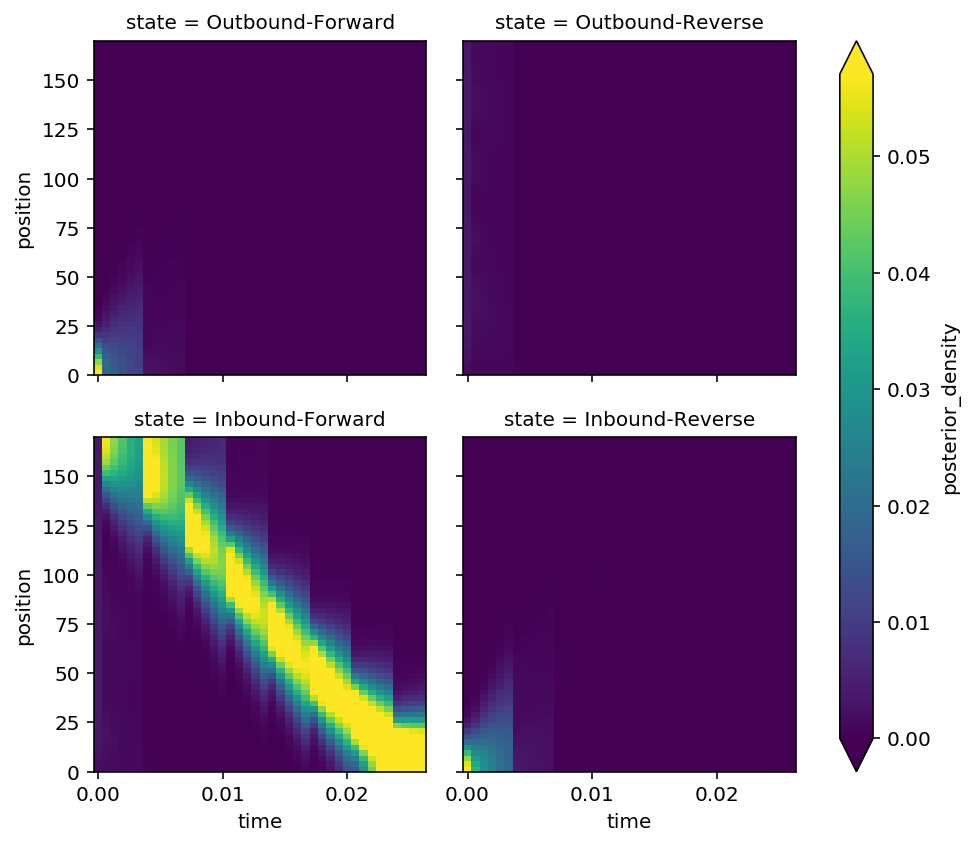

In [31]:
inbound_forward_results.plot_posterior_density()

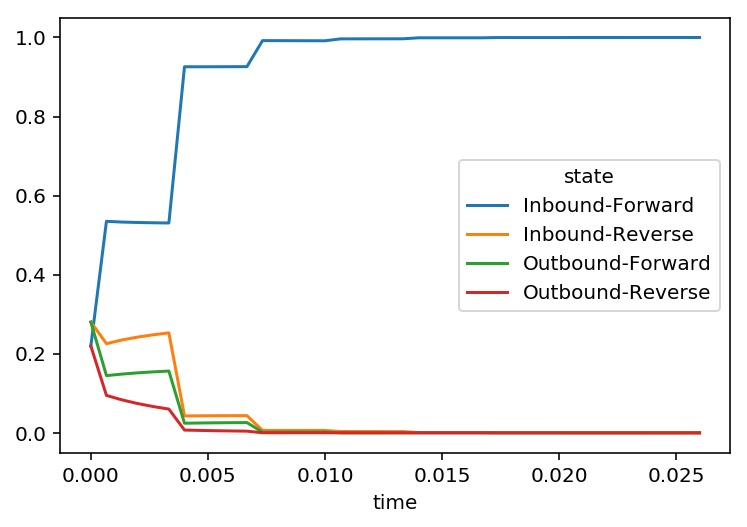

In [32]:
inbound_forward_results.plot_state_probability()

In [34]:
inbound_forward_results.plot_interactive()

:Layout
   .GridSpace.I   :GridSpace   [state]
      :HoloMap   [time]
         :Curve   [position]   (prior)
   .GridSpace.II  :GridSpace   [state]
      :HoloMap   [time]
         :Curve   [position]   (likelihood)
   .GridSpace.III :GridSpace   [state]
      :HoloMap   [time]
         :Curve   [position]   (posterior_density)

### Inbound-Reverse

In [33]:
inbound_reverse_spike_marks = np.full((4, n_replay_time, 4), np.nan)
inbound_reverse_spike_marks[0, 1, :] = mark_means[0]
inbound_reverse_spike_marks[1, 6, :] = mark_means[0]
inbound_reverse_spike_marks[0, 11, :] = mark_means[1]
inbound_reverse_spike_marks[1, 16, :] = mark_means[1]
inbound_reverse_spike_marks[0, 21, :] = mark_means[2]
inbound_reverse_spike_marks[1, 26, :] = mark_means[2]
inbound_reverse_spike_marks[0, 31, :] = mark_means[3]
inbound_reverse_spike_marks[1, 36, :] = mark_means[3]

In [34]:
inbound_reverse_results = replay_decoder.predict(inbound_reverse_spike_marks, replay_time)

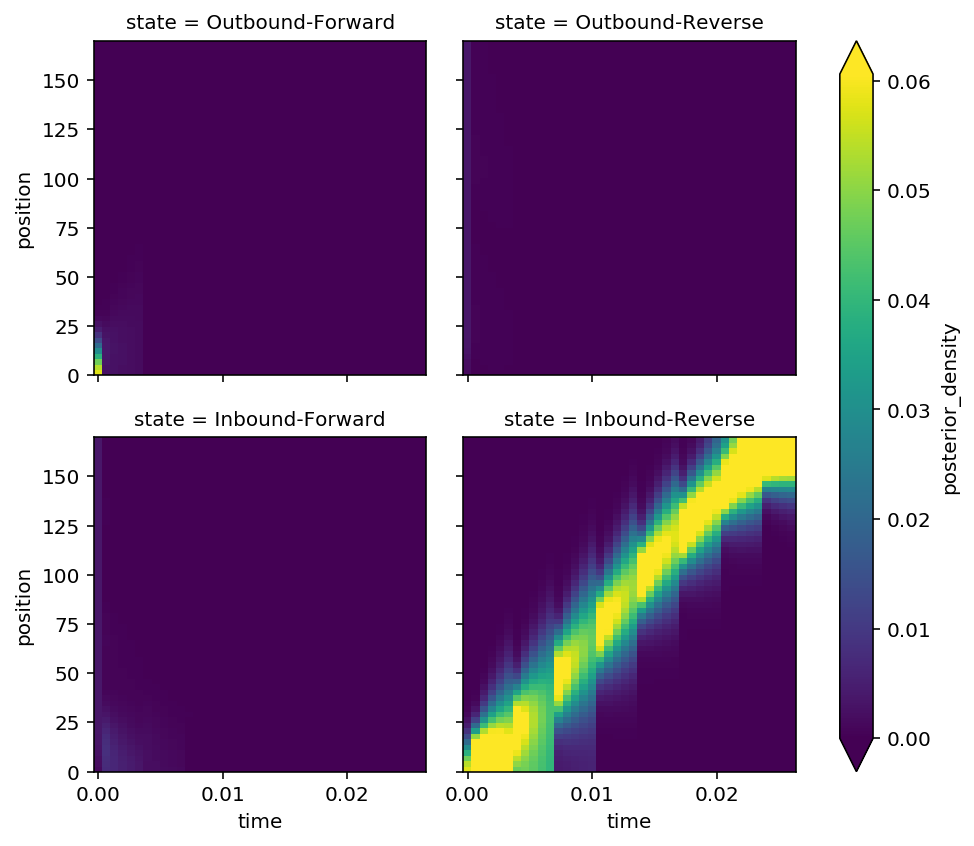

In [35]:
inbound_reverse_results.plot_posterior_density()

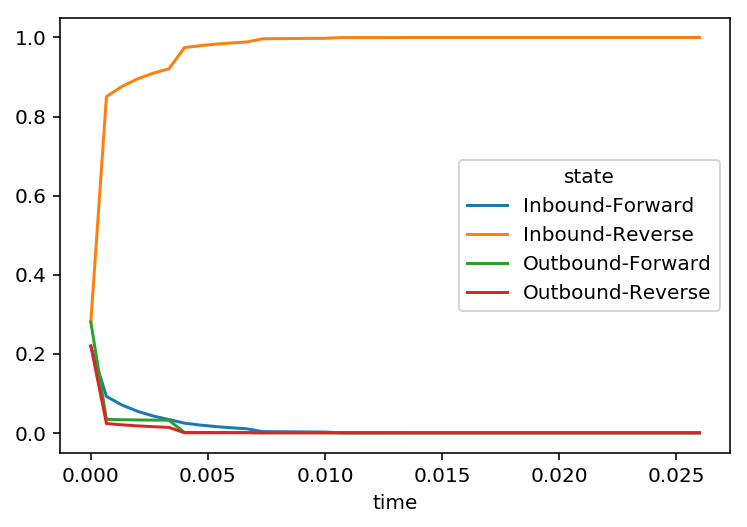

In [36]:
inbound_reverse_results.plot_state_probability()

In [39]:
inbound_reverse_results.plot_interactive()

:Layout
   .GridSpace.I   :GridSpace   [state]
      :HoloMap   [time]
         :Curve   [position]   (prior)
   .GridSpace.II  :GridSpace   [state]
      :HoloMap   [time]
         :Curve   [position]   (likelihood)
   .GridSpace.III :GridSpace   [state]
      :HoloMap   [time]
         :Curve   [position]   (posterior_density)